Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

The following is a logistic model with L2 regularization introduced. The amount of regularization corresponds to the value of the l2_lambda variable, which we will first set to 0.01

In [66]:
batch_size = 128
l2_lambda = 0.01

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # Introduce l2 regularization
  loss = tf.reduce_mean(loss + l2_lambda * tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [68]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 45.955318
Minibatch accuracy: 11.7%
Validation accuracy: 12.3%
Minibatch loss at step 1500: 0.923110
Minibatch accuracy: 78.1%
Validation accuracy: 80.2%
Minibatch loss at step 3000: 0.851226
Minibatch accuracy: 78.1%
Validation accuracy: 81.0%
Test accuracy: 88.5%


We will now tune the parameter l2_lambda by trying different values for it and comparing the outcomes.

In [102]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  l2_lambda = tf.placeholder(tf.float32)
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # Introduce l2 regularization
  loss = tf.reduce_mean(loss + l2_lambda * tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

num_steps = 3000
lambda_vals = np.arange(0,.01,.001)
accuracy_vals = []

for lambda_val in lambda_vals:
    with tf.Session(graph=graph) as session:
      print("lambda value: %f" % lambda_val)
      tf.global_variables_initializer().run()
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, l2_lambda : lambda_val}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step == 3000):
          print("Minibatch loss: %f" % l)
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
      accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))

lambda value: 0.000000
Test accuracy: 86.7%
lambda value: 0.001000
Test accuracy: 89.0%
lambda value: 0.002000
Test accuracy: 88.7%
lambda value: 0.003000
Test accuracy: 88.5%
lambda value: 0.004000
Test accuracy: 88.4%
lambda value: 0.005000
Test accuracy: 88.2%
lambda value: 0.006000
Test accuracy: 88.1%
lambda value: 0.007000
Test accuracy: 87.9%
lambda value: 0.008000
Test accuracy: 87.9%
lambda value: 0.009000
Test accuracy: 87.8%


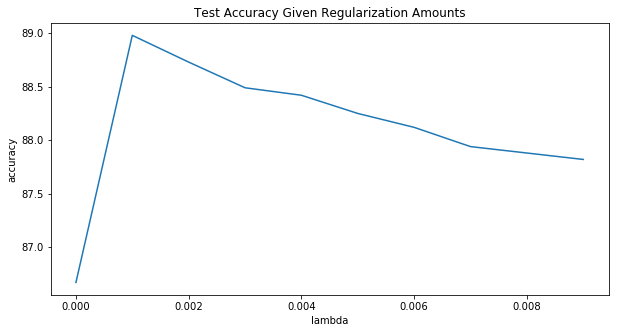

In [103]:
fig, ax = plt.subplots(figsize=[10,5])
      
ax.plot(lambda_vals, accuracy_vals)

ax.set_xlabel("lambda")
ax.set_ylabel("accuracy")
ax.set_title("Test Accuracy Given Regularization Amounts")

It seems that values outside of the range [0, 0.0016] do not help in tuning l2_lambda, but we should examine the range [0, 0.0016] in more detail.

In [104]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  l2_lambda = tf.placeholder(tf.float32)
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # Introduce l2 regularization
  loss = tf.reduce_mean(loss + l2_lambda * tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

num_steps = 3000
lambda_vals = np.arange(0,.0016,.0001)
accuracy_vals = []

for lambda_val in lambda_vals:
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, l2_lambda : lambda_val}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))

Optimal l2_lambda value: 0.001300
Accuracy with this amount of regularization: 88.860000


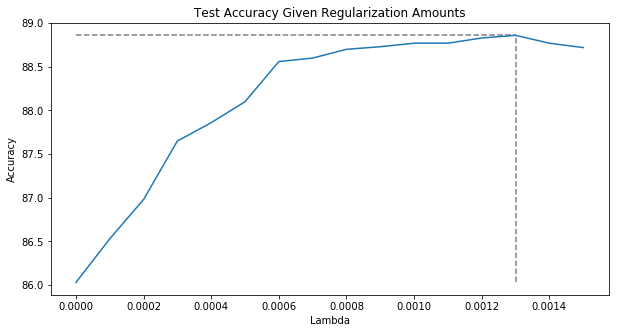

In [108]:
fig, ax = plt.subplots(figsize=[10,5])

best_ind = np.argmax(accuracy_vals)
best_lambda = lambda_vals[best_ind]
best_accuracy = accuracy_vals[best_ind]
ax.plot(lambda_vals, accuracy_vals)
ax.hlines(y=best_accuracy, xmin=np.min(lambda_vals), xmax=best_lambda, color='gray', linestyle='--')
ax.vlines(x=best_lambda, ymin=np.min(accuracy_vals), ymax=np.max(accuracy_vals), color='gray', linestyle='--')

ax.set_xlabel("Lambda")
ax.set_ylabel("Accuracy")
ax.set_title("Test Accuracy Given Regularization Amounts")

print("Optimal l2_lambda value: %f\nAccuracy with this amount of regularization: %f" % (best_lambda, best_accuracy))

---
The following introduces l2 regularization to a 1-hidden layer neural network with rectified linear units and 1024 hidden nodes. The amount of regularization corresponds to the value of the l2_lambda variable

In [109]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Hidden layer
  hidden_nodes = 1024
  hidden_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  hidden_biases = tf.Variable(tf.zeros([hidden_nodes]))
  hidden_output = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  l2_lambda = tf.placeholder(tf.float32)

  # Training computation.
  logits = tf.matmul(hidden_output, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # Introduce l2 regularization
  loss = tf.reduce_mean(loss + l2_lambda * (tf.nn.l2_loss(hidden_weights) + tf.nn.l2_loss(weights)))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)


num_steps = 3000
lambda_vals = np.arange(0,.01,.001)
accuracy_vals = []

for lambda_val in lambda_vals:
    with tf.Session(graph=graph) as session:
      print("lambda value: %f" % lambda_val)
      tf.global_variables_initializer().run()
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, l2_lambda : lambda_val}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step == 3000):
          print("Minibatch loss: %f" % l)
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
      accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))

lambda value: 0.000000
Test accuracy: 89.5%
lambda value: 0.001000
Test accuracy: 93.2%
lambda value: 0.002000
Test accuracy: 93.1%
lambda value: 0.003000
Test accuracy: 92.5%
lambda value: 0.004000
Test accuracy: 92.0%
lambda value: 0.005000
Test accuracy: 91.7%
lambda value: 0.006000
Test accuracy: 91.2%
lambda value: 0.007000
Test accuracy: 90.7%
lambda value: 0.008000
Test accuracy: 90.5%
lambda value: 0.009000
Test accuracy: 90.2%


Optimal l2_lambda value: 0.001000
Accuracy with this amount of regularization: 93.150000


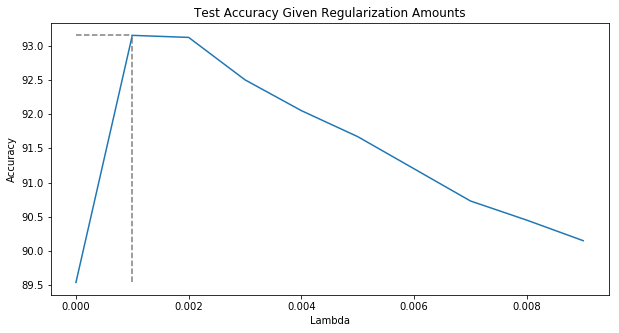

In [111]:
fig, ax = plt.subplots(figsize=[10,5])

best_ind = np.argmax(accuracy_vals)
best_lambda = lambda_vals[best_ind]
best_accuracy = accuracy_vals[best_ind]
ax.plot(lambda_vals, accuracy_vals)
ax.hlines(y=best_accuracy, xmin=np.min(lambda_vals), xmax=best_lambda, color='gray', linestyle='--')
ax.vlines(x=best_lambda, ymin=np.min(accuracy_vals), ymax=np.max(accuracy_vals), color='gray', linestyle='--')

ax.set_xlabel("Lambda")
ax.set_ylabel("Accuracy")
ax.set_title("Test Accuracy Given Regularization Amounts")

print("Optimal l2_lambda value: %f\nAccuracy with this amount of regularization: %f" % (best_lambda, best_accuracy))

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [134]:
batch_size = 128
l2_lambda = 0.001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Hidden layer
  hidden_nodes = 1024
  hidden_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  hidden_biases = tf.Variable(tf.zeros([hidden_nodes]))
  hidden_output = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(hidden_output, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # Introduce l2 regularization
  loss = tf.reduce_mean(loss + l2_lambda * (tf.nn.l2_loss(hidden_weights) + tf.nn.l2_loss(weights)))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)


num_steps = 3000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset %= 5
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if not (step % 300):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 689.143616
Minibatch accuracy: 8.6%
Validation accuracy: 35.0%
Minibatch loss at step 300: 232.613083
Minibatch accuracy: 100.0%
Validation accuracy: 65.6%
Minibatch loss at step 600: 172.310745
Minibatch accuracy: 100.0%
Validation accuracy: 65.6%
Minibatch loss at step 900: 127.641502
Minibatch accuracy: 100.0%
Validation accuracy: 65.6%
Minibatch loss at step 1200: 94.551956
Minibatch accuracy: 100.0%
Validation accuracy: 65.6%
Minibatch loss at step 1500: 70.040672
Minibatch accuracy: 100.0%
Validation accuracy: 65.6%
Minibatch loss at step 1800: 51.883499
Minibatch accuracy: 100.0%
Validation accuracy: 65.6%
Minibatch loss at step 2100: 38.433308
Minibatch accuracy: 100.0%
Validation accuracy: 65.7%
Minibatch loss at step 2400: 28.469997
Minibatch accuracy: 100.0%
Validation accuracy: 65.7%
Minibatch loss at step 2700: 21.089527
Minibatch accuracy: 100.0%
Validation accuracy: 65.8%
Test accuracy: 73.4%


In this case, the minibatch accuracy rises to 100%. The model exactly fits to the data in the 5 mini-batches that are allowed. However, the validation accuracy remains low and the test accuracy of the fully trained model is relatively low. The model has overfit to the limited training data.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [157]:
batch_size = 128
l2_lambda = 0.001
keep_prob = 0.4

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Hidden layer
  hidden_nodes = 1024
  hidden_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  hidden_biases = tf.Variable(tf.zeros([hidden_nodes]))
  hidden_output = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(tf.nn.dropout(hidden_output, keep_prob), weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # Introduce l2 regularization
  loss = tf.reduce_mean(loss + l2_lambda * (tf.nn.l2_loss(hidden_weights) + tf.nn.l2_loss(weights)))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)


num_steps = 3000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset %= 5
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if not (step % 300):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 847.549988
Minibatch accuracy: 9.4%
Validation accuracy: 26.5%
Minibatch loss at step 300: 233.950485
Minibatch accuracy: 100.0%
Validation accuracy: 71.9%
Minibatch loss at step 600: 173.333710
Minibatch accuracy: 100.0%
Validation accuracy: 72.6%
Minibatch loss at step 900: 128.421387
Minibatch accuracy: 100.0%
Validation accuracy: 72.6%
Minibatch loss at step 1200: 95.141678
Minibatch accuracy: 100.0%
Validation accuracy: 71.9%
Minibatch loss at step 1500: 70.483292
Minibatch accuracy: 100.0%
Validation accuracy: 72.3%
Minibatch loss at step 1800: 52.212254
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 2100: 38.677685
Minibatch accuracy: 100.0%
Validation accuracy: 72.8%
Minibatch loss at step 2400: 28.651480
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 2700: 21.224735
Minibatch accuracy: 100.0%
Validation accuracy: 73.3%
Test accuracy: 80.5%


The above model, like the one in problem 3, overfits as the training data is limited to five different minibatches, but further introduces dropout. Once again, the model memorizes the training data, as the accuracy on mini-batches is much higher than on the validation set and on the test set, but the effects of overfitting are not as adverse, but performs much better on each validation set and the test set.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [187]:
batch_size = 128
l2_lambda = 0.0013
keep_prob = 0.8

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Hidden layer
  h1_nodes = 2048
  h2_nodes = 1024
  h3_nodes = 128
  h4_nodes = 64
  
  # Variables.
  W1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, h1_nodes], stddev=np.sqrt(2.0/(image_size*image_size))))
  b1 = tf.Variable(tf.zeros([h1_nodes]))
  W2 = tf.Variable(
    tf.truncated_normal([h1_nodes, h2_nodes], stddev=np.sqrt(2.0/h1_nodes)))
  b2 = tf.Variable(tf.zeros([h2_nodes]))
  W3 = tf.Variable(
    tf.truncated_normal([h2_nodes, h3_nodes], stddev=np.sqrt(2.0/h2_nodes)))
  b3 = tf.Variable(tf.zeros([h3_nodes]))
  W4 = tf.Variable(
    tf.truncated_normal([h3_nodes, num_labels], stddev=np.sqrt(2.0/h3_nodes)))
  b4 = tf.Variable(tf.zeros([num_labels]))
  global_step = tf.Variable(0)

  # Training computation.
  y1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1), keep_prob)
  y2 = tf.nn.dropout(tf.nn.relu(tf.matmul(y1, W2) + b2), keep_prob)
  y3 = tf.nn.dropout(tf.nn.relu(tf.matmul(y2, W3) + b3), keep_prob)
  logits = tf.nn.relu(tf.matmul(y3, W4) + b4)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # Introduce l2 regularization
  loss = tf.reduce_mean(loss + l2_lambda * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4)))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.14, global_step, 100000, 0.95, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1), W2) + b2), W3) + b3), W4) + b4)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1), W2) + b2), W3) + b3), W4) + b4)

num_steps = 20000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if not (step % 3000):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 5.597457
Minibatch accuracy: 7.0%
Validation accuracy: 21.7%
Minibatch loss at step 3000: 1.619623
Minibatch accuracy: 83.6%
Validation accuracy: 87.6%
Minibatch loss at step 6000: 0.709474
Minibatch accuracy: 93.8%
Validation accuracy: 88.5%
Minibatch loss at step 9000: 0.664376
Minibatch accuracy: 87.5%
Validation accuracy: 88.5%
Minibatch loss at step 12000: 0.454409
Minibatch accuracy: 91.4%
Validation accuracy: 88.7%
Minibatch loss at step 15000: 0.464177
Minibatch accuracy: 93.0%
Validation accuracy: 88.6%
Minibatch loss at step 18000: 0.801050
Minibatch accuracy: 79.7%
Validation accuracy: 88.7%
Test accuracy: 95.2%


In [188]:
batch_size = 128
l2_lambda = 0.0013
keep_prob = 0.8

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Hidden layer
  h1_nodes = 2048
  h2_nodes = 1024
  h3_nodes = 128
  h4_nodes = 64
  
  # Variables.
  W1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, h1_nodes], stddev=np.sqrt(2.0/(image_size*image_size))))
  b1 = tf.Variable(tf.zeros([h1_nodes]))
  W2 = tf.Variable(
    tf.truncated_normal([h1_nodes, h2_nodes], stddev=np.sqrt(2.0/h1_nodes)))
  b2 = tf.Variable(tf.zeros([h2_nodes]))
  W3 = tf.Variable(
    tf.truncated_normal([h2_nodes, h3_nodes], stddev=np.sqrt(2.0/h2_nodes)))
  b3 = tf.Variable(tf.zeros([h3_nodes]))
  W4 = tf.Variable(
    tf.truncated_normal([h3_nodes, num_labels], stddev=np.sqrt(2.0/h3_nodes)))
  b4 = tf.Variable(tf.zeros([num_labels]))
  global_step = tf.Variable(0)

  # Training computation.
  def model(data, train=False):
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    if train: 
        y1 = tf.nn.dropout(y1, keep_prob)
    y2 = tf.nn.relu(tf.matmul(y1, W2) + b2)
    if train:
        y2 = tf.nn.dropout(y2, keep_prob)
    y3 = tf.nn.relu(tf.matmul(y2, W3) + b3)
    if train:
        y3 = tf.nn.dropout(y3)
    y4 = tf.nn.relu(tf.matmul(y3, W4) + b4)
  
  logits = model(tf_train_dataset, train=True)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # Introduce l2 regularization
  loss = tf.reduce_mean(loss + l2_lambda * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4)))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.14, global_step, 100000, 0.95, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

num_steps = 20000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if not (step % 3000):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 5.581643
Minibatch accuracy: 7.8%
Validation accuracy: 19.9%
Minibatch loss at step 3000: 1.628539
Minibatch accuracy: 85.9%
Validation accuracy: 87.4%
Minibatch loss at step 6000: 0.710553
Minibatch accuracy: 93.8%
Validation accuracy: 88.5%
Minibatch loss at step 9000: 0.621241
Minibatch accuracy: 87.5%
Validation accuracy: 88.8%
Minibatch loss at step 12000: 0.445176
Minibatch accuracy: 90.6%
Validation accuracy: 88.9%
Minibatch loss at step 15000: 0.457421
Minibatch accuracy: 90.6%
Validation accuracy: 88.9%
Minibatch loss at step 18000: 0.773822
Minibatch accuracy: 79.7%
Validation accuracy: 88.9%
Minibatch loss at step 21000: 0.534659
Minibatch accuracy: 90.6%
Validation accuracy: 89.1%
Minibatch loss at step 24000: 0.407268
Minibatch accuracy: 93.8%
Validation accuracy: 89.2%
Minibatch loss at step 27000: 0.392393
Minibatch accuracy: 94.5%
Validation accuracy: 89.4%
Test accuracy: 95.1%
